In [74]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder


In [75]:
#Load the data
train= pd.read_csv('Train.csv')
test = pd.read_csv('Test (1).csv')
submission = pd.read_csv('SampleSubmission (2).csv')

We would like to join the two datasets together so that we can do feature engineering on both of them but we will split them before data model training to avoid data leakage. 

In [76]:
#check for null values
train.isnull().sum()

ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
target    0
dtype: int64

In [77]:
test.isnull().sum()

ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
dtype: int64

The datasets have no null values 

Since the column 'ID' is different in both datasets  we will have to drop and leave only the columns that are similar

In [78]:
train = train.drop(columns='ID')
test = test.drop(columns='ID')
#The target column is removed from the dataset and fitted into another data_frame
train_target = train['target']
train_copy = train.drop(columns='target')
#Combining the train and test dataset
combined_data = pd.concat([train_copy,test],ignore_index=True)
combined_data

In [80]:
#The target column is removed from the dataset and fitted into another data_frame
train_target = train['target']
train_copy = train.drop(columns='target')

In [81]:
train_copy.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU


In [82]:
#Combining the train and test dataset
combined_data = pd.concat([train_copy,test],ignore_index=True)
combined_data

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU
...,...,...,...,...,...,...,...,...
117161,2018-09-12,TU 0998,TUN,NCE,2018-09-12 14:15:00,2018-09-12 15.45.00,ATA,TU 320IMV
117162,2018-09-27,WKL 0000,TUN,TUN,2018-09-27 22:00:00,2018-09-28 01.00.00,SCH,TU 32AIMG
117163,2018-09-03,UG 1601,SJJ,TUN,2018-09-03 09:20:00,2018-09-03 11.10.00,SCH,TU CR9ISA
117164,2018-09-15,UG 0008,TUN,DJE,2018-09-15 14:30:00,2018-09-15 15.30.00,SCH,UG AT7LBD


In [83]:
#convert all the columns with dates to datetime format
combined_data['STD'] = pd.to_datetime(combined_data['STD'])
combined_data['STA'] = pd.to_datetime(combined_data['STA'], format='%Y-%m-%d %H.%M.%S')
combined_data['DATOP'] = pd.to_datetime(combined_data['DATOP'])

In [84]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117166 entries, 0 to 117165
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATOP   117166 non-null  datetime64[ns]
 1   FLTID   117166 non-null  object        
 2   DEPSTN  117166 non-null  object        
 3   ARRSTN  117166 non-null  object        
 4   STD     117166 non-null  datetime64[ns]
 5   STA     117166 non-null  datetime64[ns]
 6   STATUS  117166 non-null  object        
 7   AC      117166 non-null  object        
dtypes: datetime64[ns](3), object(5)
memory usage: 7.2+ MB


In [85]:
#Adding the duration column 
# Calculate the time difference between 'STD' and 'STA'
combined_data['Duration'] = combined_data['STA'] - combined_data['STD']
combined_data['Duration'] = combined_data['Duration'].dt.total_seconds()/ 60

In [86]:
min_value = combined_data['Duration'].min()

# Find the maximum value in the 'column_name' column
max_value = combined_data['Duration'].max()

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 10.0
Maximum value: 719520.0


In [87]:
combined_data.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,Duration
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,145.0
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,110.0
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,155.0
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,170.0
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,80.0


In [88]:
#Year', 'Month','Day', 'Dayofweek', 'Dayofyear',

# Extract hour, minute, day, month, and year from 'STD' and 'STA'
combined_data['Dep_hour'] =   combined_data['STD'].dt.hour
combined_data['Dep_minute'] = combined_data['STD'].dt.minute
combined_data['Dep_day'] = combined_data['STD'].dt.day
combined_data['Dep_month'] = combined_data['STD'].dt.month
combined_data['Dep_year'] = combined_data['STD'].dt.year

combined_data['Arr_hour'] =   combined_data['STA'].dt.hour
combined_data['Arr_minute'] = combined_data['STA'].dt.minute
combined_data['Arr_day'] = combined_data['STA'].dt.day
combined_data['Arr_month'] = combined_data['STA'].dt.month
combined_data['Arr_year'] = combined_data['STA'].dt.year

combined_data['Day_of_year'] = combined_data['DATOP'].dt.dayofyear
combined_data['D_Day'] =    combined_data['DATOP'].dt.day
combined_data['D_Day_of_week'] =    combined_data['DATOP'].dt.dayofweek
combined_data['D_month'] =  combined_data['DATOP'].dt.month
combined_data['D_year'] =   combined_data['DATOP'].dt.year





In [89]:
combined_data.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,Duration,Dep_hour,...,Arr_hour,Arr_minute,Arr_day,Arr_month,Arr_year,Day_of_year,D_Day,D_Day_of_week,D_month,D_year
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,145.0,10,...,12,55,3,1,2016,3,3,6,1,2016
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,110.0,15,...,16,55,13,1,2016,13,13,2,1,2016
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,155.0,4,...,6,45,16,1,2016,16,16,5,1,2016
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,170.0,14,...,17,0,17,1,2016,17,17,6,1,2016
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,80.0,14,...,15,50,17,1,2016,17,17,6,1,2016


In [90]:
#Extracting from FLTID , name of airline
combined_data['Airlinename'] = combined_data['FLTID'].apply(lambda x: x.split(' ')[0] )
#Extracting from FLTID , name of company 


### Encoding the categorical variables

In [91]:
combined_data.columns

Index(['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC',
       'Duration', 'Dep_hour', 'Dep_minute', 'Dep_day', 'Dep_month',
       'Dep_year', 'Arr_hour', 'Arr_minute', 'Arr_day', 'Arr_month',
       'Arr_year', 'Day_of_year', 'D_Day', 'D_Day_of_week', 'D_month',
       'D_year', 'Airlinename'],
      dtype='object')

In [92]:
#Label Encoding 
col=['FLTID','Airlinename','AC','D_year','Dep_year','Arr_year']
labelencoder = LabelEncoder()
for i in col:
    combined_data[i] = labelencoder.fit_transform(combined_data[i])

In [93]:
#One_hot_encoding
# One-hot encode categorical columns
combined_data = pd.get_dummies(combined_data, columns=['STATUS','DEPSTN','ARRSTN'])

# Display the encoded trainFrame
combined_data.head()

,DATOP,FLTID,STD,STA,AC,Duration,Dep_hour,Dep_minute,Dep_day,Dep_month,...,ARRSTN_TRN,ARRSTN_TUN,ARRSTN_VCE,ARRSTN_VIE,ARRSTN_VKO,ARRSTN_VNO,ARRSTN_VOG,ARRSTN_VRN,ARRSTN_YUL,ARRSTN_ZRH
0,2016-01-03,239,2016-01-03 10:30:00,2016-01-03 12:55:00,47,145.0,10,30,3,1,...,False,True,False,False,False,False,False,False,False,False
1,2016-01-13,266,2016-01-13 15:05:00,2016-01-13 16:55:00,29,110.0,15,5,13,1,...,False,True,False,False,False,False,False,False,False,False
2,2016-01-16,93,2016-01-16 04:10:00,2016-01-16 06:45:00,47,155.0,4,10,16,1,...,False,False,False,False,False,False,False,False,False,False
3,2016-01-17,173,2016-01-17 14:10:00,2016-01-17 17:00:00,51,170.0,14,10,17,1,...,False,False,False,False,False,False,False,False,False,False
4,2016-01-17,145,2016-01-17 14:30:00,2016-01-17 15:50:00,35,80.0,14,30,17,1,...,False,False,False,False,False,False,False,False,False,False


In [94]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117166 entries, 0 to 117165
Columns: 291 entries, DATOP to ARRSTN_ZRH
dtypes: bool(269), datetime64[ns](3), float64(1), int32(15), int64(3)
memory usage: 43.0 MB


In [95]:
combined_data = combined_data.drop(columns=['DATOP','STD','STA'])

In [96]:
#SLICING THE DATASET
train_data = combined_data[:len(train)]
test_data = combined_data[len(train):]

In [97]:
#adding back the target to the column
train_data['target'] = train_target

In [98]:
train_data.columns

Index(['FLTID', 'AC', 'Duration', 'Dep_hour', 'Dep_minute', 'Dep_day',
       'Dep_month', 'Dep_year', 'Arr_hour', 'Arr_minute',
       ...
       'ARRSTN_TUN', 'ARRSTN_VCE', 'ARRSTN_VIE', 'ARRSTN_VKO', 'ARRSTN_VNO',
       'ARRSTN_VOG', 'ARRSTN_VRN', 'ARRSTN_YUL', 'ARRSTN_ZRH', 'target'],
      dtype='object', length=289)

In [99]:

from scipy import stats
#get zscores of target variable
z_scores = stats.zscore(train_data['target'])
#get absolute values of target variable
abs_z_scores = np.abs(z_scores)
#filter dataframe
filtered_enteries = (abs_z_scores < 3)
train_df =train_data[filtered_enteries]

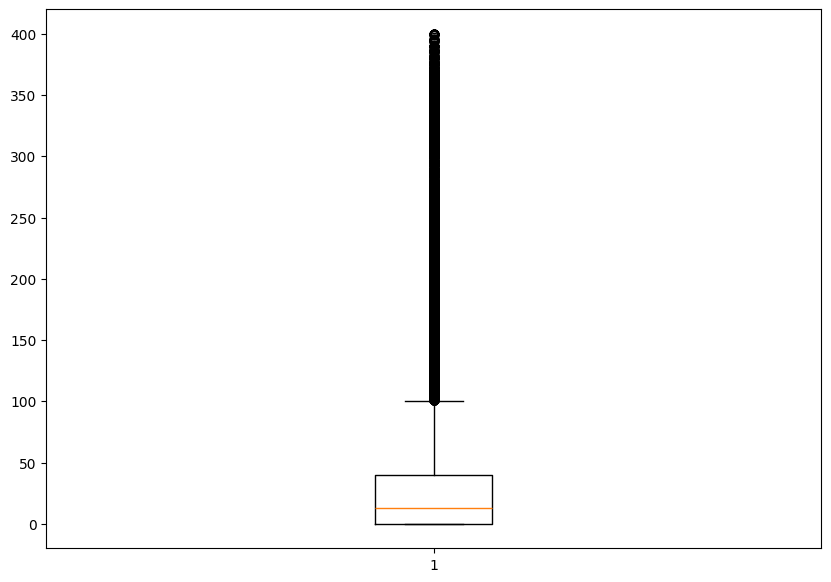

In [100]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(train_df['target'])

# show plot
plt.show()

###MODEL

In [101]:
X = train_df.drop(columns=['target'])
y = train_df['target']

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105894 entries, 0 to 107832
Columns: 288 entries, FLTID to ARRSTN_ZRH
dtypes: bool(269), float64(1), int32(15), int64(3)
memory usage: 37.3 MB


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your pandas code here

# Reset warnings to default behavior (optional)
#warnings.resetwarnings()


In [105]:
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor(enable_categorical=True)
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [0.025], #so called `eta` value
              'max_depth': [7,8],
              'min_child_weight': [4],
              'subsample': [0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [200,300],
               'silent':[1],
                'nthread': [4]}

xgb_grid = GridSearchCV(xgb_model,parameters,cv = 5,verbose=True,scoring='neg_mean_squared_error')
xgb_grid.fit(X,y)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 300, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.9}


In [106]:
# Get the best estimator
best_model = xgb_grid.best_estimator_

predictions = best_model.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))

print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 52.49448040436148


In [107]:
param= {'colsample_bytree': 0.7, 'learning_rate': 0.025, 'max_depth': 8,
        'min_child_weight': 4, 'n_estimators': 200, 'nthread': 4,
        'objective': 'reg:linear', 'silent': 1, 'subsample': 0.9}
xgb_other = XGBRegressor(**param,enable_categorical=True)
xgb_other.fit(X,y)
pred = xgb_other.predict(test_data)


In [108]:
pred

array([17.64678   , 27.559853  , 25.784725  , ...,  0.42700386,
        1.615376  , -0.03915958], dtype=float32)

In [109]:
sub1=pd.DataFrame()
sub1['ID'] = submission['ID']

In [110]:
sub1['target'] = pred

In [111]:
sub1.head()

,ID,target
0,test_id_0,17.646780
1,test_id_1,27.559853
2,test_id_2,25.784725
3,test_id_3,17.188835
4,test_id_4,24.686460


In [112]:
sub1['target'] = sub1['target'].round().astype(int)


# Replace any negative values with zero
sub1['target'] = sub1['target'].apply(lambda x: max(0, x))


In [113]:
sub1.to_csv('sub4.csv', index=False)

In [114]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest RMSE: {rmse_rf}')


Random Forest RMSE: 55.867087365952244


In [66]:
import lightgbm as lgb

# Initialize and train the model
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)
lgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f'LightGBM RMSE: {rmse_lgb}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 84207, number of used features: 178
[LightGBM] [Info] Start training from score 35.669256
LightGBM RMSE: 50.70752662164618


In [67]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

 

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE')

# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred_cbr = model.predict(X_test)

# Evaluate the model
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cbr))
print(f'CatBoost RMSE: {rmse_cb}')


0:	learn: 58.5993066	total: 167ms	remaining: 2m 47s
1:	learn: 58.0418966	total: 188ms	remaining: 1m 33s
2:	learn: 57.5804345	total: 208ms	remaining: 1m 9s
3:	learn: 57.1783903	total: 225ms	remaining: 56s
4:	learn: 56.8374346	total: 239ms	remaining: 47.5s
5:	learn: 56.5052642	total: 249ms	remaining: 41.3s
6:	learn: 56.2440817	total: 259ms	remaining: 36.7s
7:	learn: 56.0341730	total: 267ms	remaining: 33.1s
8:	learn: 55.8505848	total: 276ms	remaining: 30.4s
9:	learn: 55.6771856	total: 283ms	remaining: 28s
10:	learn: 55.5222684	total: 292ms	remaining: 26.3s
11:	learn: 55.3659264	total: 299ms	remaining: 24.6s
12:	learn: 55.2465096	total: 307ms	remaining: 23.3s
13:	learn: 55.1364009	total: 313ms	remaining: 22.1s
14:	learn: 55.0498846	total: 321ms	remaining: 21.1s
15:	learn: 54.9575298	total: 328ms	remaining: 20.2s
16:	learn: 54.8544643	total: 335ms	remaining: 19.4s
17:	learn: 54.7835862	total: 343ms	remaining: 18.7s
18:	learn: 54.6998564	total: 350ms	remaining: 18s
19:	learn: 54.6504157	tota

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and train the model
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_knn = knn_model.predict(X_test_scaled)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print(f'KNN RMSE: {rmse_knn}')


KNN RMSE: 56.41925680542198


In [70]:
from sklearn.linear_model import Lasso

# Initialize and train the model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_lasso = lasso_model.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f'LASSO RMSE: {rmse_lasso}')


LASSO RMSE: 54.871242780731286


In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# Initialize and train the model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(288,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
  ])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
ann_model.compile(optimizer='adam', loss='mean_squared_error')
history = ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping])

# Predictions and evaluation
y_pred_ann = ann_model.predict(X_test_scaled)
rmse_ann = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print(f'ANN RMSE: {rmse_ann}')


Epoch 1/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 3295.7708 - val_loss: 3093.0127
Epoch 2/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2950.2932 - val_loss: 3015.7268
Epoch 3/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2898.2163 - val_loss: 2995.4387
Epoch 4/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2842.9624 - val_loss: 2992.3792
Epoch 5/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2791.8848 - val_loss: 2964.1360
Epoch 6/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2799.0120 - val_loss: 2960.6072
Epoch 7/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2772.9775 - val_loss: 2987.3618
Epoch 8/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2727.3044 - val_loss: 2983.8306
Epoch 9/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2784.2742 - val_loss: 2950.2256
Epoch 10/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2775.9341 - val_loss: 3013.5674
Epoch 11/50
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lo

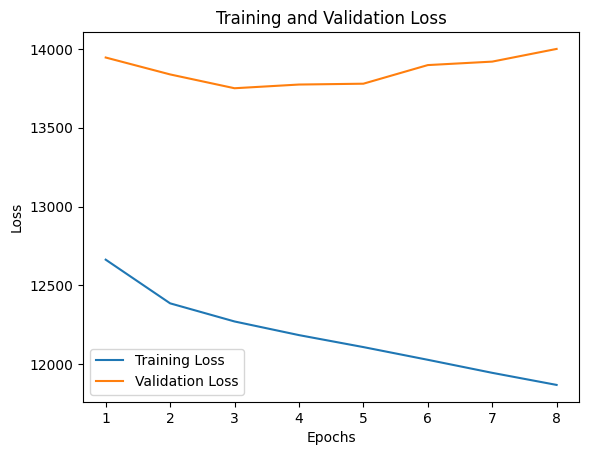

In [ ]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [73]:
print(f'XGBoost RMSE: {rmse}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'ANN RMSE: {rmse_ann}')
print(f'KNN RMSE: {rmse_knn}')
print(f'LASSO RMSE: {rmse_lasso}')
print(f'LightGBM RMSE: {rmse_lgb}')
print(f'Catboost RMSE: {rmse_cb}')



XGBoost RMSE: 48.560395491590796
Random Forest RMSE: 50.52085399386596
ANN RMSE: 53.12408601339468
KNN RMSE: 56.41925680542198
LASSO RMSE: 54.871242780731286
LightGBM RMSE: 50.70752662164618
Catboost RMSE: 50.4207935506464
